In [1]:
#mount google drive when on google colab and set working directory

import sys
import os

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/music_speech/')

working_dir = os.getcwd()
print(f'\nWorking directory: {working_dir}')


Working directory: /Users/kraehenb/music_speech


In [2]:
#check working directory and repo (git clone git@github.com:jkcas22/music_speech.git)

!{sys.executable} -m pip install gitpython
import git

repo = ['git@github.com:jkcas22/music_speech.git', 'https://github.com/jkcas22/music_speech.git']

if git.Repo(working_dir).remotes.origin.url in repo:
    print(f'\nRepository and working directory are fine.')
else:
    print(f'\nRepository: {git.Repo(working_dir).remotes.origin.url}')


Repository and working directory are fine.


In [3]:
#initialize environment, load modules/libraries

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#import python code from seperate files
from helpers.fourier_transform import load_wav, dft_logmag, patches

2023-02-21 21:03:13.133974: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
music_dir = './data/music_wav'
if not os.path.isdir(music_dir): 
    print(f'copy folder "music_wav" from unzipped 34.tar to {os.path.join(working_dir, "data","")}')

music_test = [
    'unpoco.wav',
    'blues.wav',
    'gismonti.wav',
    'ipanema.wav',
    'deedee.wav',
    'hendrix.wav',
    'madradeus.wav',
    'marlene.wav',
    'beatles.wav',
    'bagpipe.wav',
    'redhot.wav',
    'jazz.wav'
]
music_test = [os.path.join(music_dir, file) for file in music_test]

music = [os.path.join(music_dir, file) for file in os.listdir(music_dir) if file.endswith('.wav')]
music = list(set(music)-set(music_test))

speech_dir = './data/speech_wav'
if not os.path.isdir(speech_dir): 
    print(f'copy folder "speech_wav" from unzipped 34.tar to {os.path.join(working_dir, "data","")}')

speech_test = [
    'comedy.wav',
    'thlui.wav',
    'voices.wav',
    'conversion.wav',
    'china.wav',
    'vegetables2.wav',
    'amal.wav',
    'teachers2.wav',
    'chant.wav',
    'pulp2.wav',
    'acomic.wav',
    'kid.wav'
]
speech_test = [os.path.join(speech_dir, file) for file in speech_test]

speech = [os.path.join(speech_dir, file) for file in os.listdir(speech_dir) if file.endswith('.wav')]
speech = list(set(speech)-set(speech_test))
	  
print (len(music), len(speech))

52 52


In [5]:
test = speech_test + music_test
test_labels = np.zeros(len(test))
test_labels[0:len(speech_test)]=1

split = len(speech)*8//10

train = speech[:split] + music[:split]
train_labels = np.zeros(len(train))
train_labels[:split]=1

validate = speech[split:] + music[split:]
validate_labels = np.zeros(len(validate))
validate_labels[:len(speech[split:])]=1

In [6]:
test_sounds = load_wav(test)
train_sounds = load_wav(train)
validate_sounds = load_wav(validate)

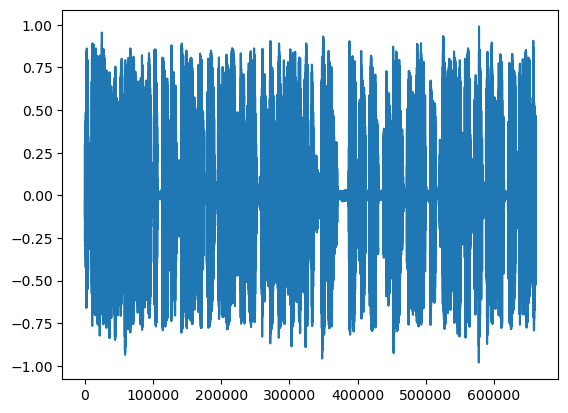

In [7]:
plt.plot(train_sounds[0])
plt.show()

In [8]:
fft_step=256
fft_size=512
fft_chunks = len(train_sounds[0])//fft_step

test_logmag = dft_logmag(test_sounds,fft_chunks,fft_step,fft_size)
train_logmag = dft_logmag(train_sounds,fft_chunks,fft_step,fft_size)
validate_logmag = dft_logmag(validate_sounds,fft_chunks,fft_step,fft_size)

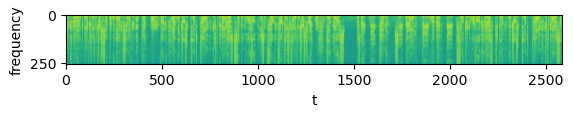

In [9]:
plt.imshow(train_logmag[0].T)
plt.xlabel('t')
plt.ylabel('frequency')
plt.show()

In [14]:
patch_step = 1
patch_size = 10

def ds_window(sound, label, patch_step, patch_size):
    labels = np.ones(len(sound))*label
    sound = np.c_[sound,labels]
    ds = tf.data.Dataset.from_tensor_slices(sound)
    ds = ds.window(size=patch_size,shift=patch_step,drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(patch_size))
    return ds

def ds_patches(sounds, labels, patch_step, patch_size):
    ds = ds_window(sounds[0],labels[0],patch_step,patch_size)
    for sound, label in zip(sounds[1:],labels[1:]): ds = ds.concatenate(ds_window(sound,label,patch_step,patch_size))
    ds = ds.map(lambda x: (x[:,:-1], x[0,-1]))
    return ds

test_ds = ds_patches(test_logmag, test_labels, patch_step, patch_size)
train_ds = ds_patches(train_logmag, train_labels, patch_step, patch_size)
validate_ds = ds_patches(validate_logmag, validate_labels, patch_step, patch_size)

n_test = test_logmag.shape[0]*(((test_logmag.shape[1]-patch_size)//patch_step)+1)
n_train = train_logmag.shape[0]*(((train_logmag.shape[1]-patch_size)//patch_step)+1)
n_validate = validate_logmag.shape[0]*(((validate_logmag.shape[1]-patch_size)//patch_step)+1)

print(f"{n_test} samples for test.")
print(f"{n_train} samples for training.")
print(f"{n_validate} samples for validation.")

61776 samples for test.
211068 samples for training.
56628 samples for validation.


In [11]:
n = 10
for sound, label in train_ds.take(n):
    sound = sound.numpy()
    print(f"{sound.shape} : {sound[[0,patch_step],0]} : {sound[[-patch_step-1,-1],0]}")

(10, 256) : [-4.67965774 -5.60482287] : [-5.63408712 -4.0462857 ]
(10, 256) : [-5.60482287 -6.2088421 ] : [-4.0462857  -5.22827082]
(10, 256) : [-6.2088421  -5.55818686] : [-5.22827082 -4.88824966]
(10, 256) : [-5.55818686 -5.81995624] : [-4.88824966 -6.20222578]
(10, 256) : [-5.81995624 -6.52355347] : [-6.20222578 -4.72371428]
(10, 256) : [-6.52355347 -4.98913796] : [-4.72371428 -4.42611766]
(10, 256) : [-4.98913796 -4.48942677] : [-4.42611766 -4.7338552 ]
(10, 256) : [-4.48942677 -5.63408712] : [-4.7338552  -8.16453816]
(10, 256) : [-5.63408712 -4.0462857 ] : [-8.16453816 -5.02093591]
(10, 256) : [-4.0462857  -5.22827082] : [-5.02093591 -6.8515598 ]


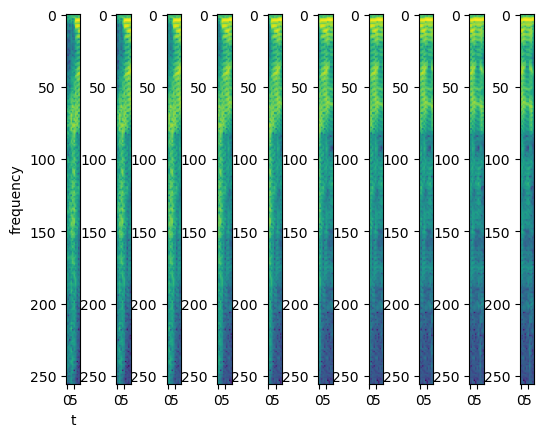

In [12]:
for i, (sound, label) in enumerate(train_ds.take(n)):
    plt.subplot(1,n,i+1)
    plt.imshow(sound.numpy().T)
    if i == 0:
        plt.xlabel('t')
        plt.ylabel('frequency')
plt.show()

In [15]:
test_ds = test_ds.shuffle(n_test).batch(patch_size)
train_ds = train_ds.shuffle(n_train).batch(patch_size)
validate_ds = validate_ds.shuffle(n_validate).batch(patch_size)

# test_x = test_ds.map(lambda x, y: x)
# test_y = test_ds.map(lambda x, y: y)

# train_x = train_ds.map(lambda x, y: x)
# train_y = train_ds.map(lambda x, y: y)

# validate_x = validate_ds.map(lambda x, y: x)
# validate_y = validate_ds.map(lambda x, y: y)

# print(f"Samples are shuffled now ... {[int(label.numpy()) for label in test_y.take(20)]} ...")

In [22]:
model = tf.keras.Sequential()
#model.add(tf.keras.layers.Embedding(vocab_size, 128, input_length=n_input))

model.add(tf.keras.layers.LSTM(256,return_sequences=True, input_shape=(10,256)))
model.add(tf.keras.layers.LSTM(512,return_sequences=True))
model.add(tf.keras.layers.LSTM(128))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='RMSProp',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 256)           525312    
                                                                 
 lstm_7 (LSTM)               (None, 10, 512)           1574912   
                                                                 
 lstm_8 (LSTM)               (None, 128)               328192    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,428,545
Trainable params: 2,428,545
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit(train_ds.take(100))

2023-02-21 21:17:54.699585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 26193 of 211068
2023-02-21 21:18:04.699597: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 53389 of 211068
2023-02-21 21:18:14.701842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 76165 of 211068
2023-02-21 21:18:24.699466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 101687 of 211068
2023-02-21 21:18:34.699937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 133230 of 211068
2023-02-21 21:18:44.806848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 163943 of 211068
2023-02-21 21:18:54.699610: I tensorflow/core/kernels/data/shuffle_dataset_op.c

    907/Unknown - 357s 284ms/step - loss: 0.6984 - accuracy: 0.5002

KeyboardInterrupt: 

In [21]:

model.evaluate(test_ds.take(100))

2023-02-21 21:15:49.416315: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 30387 of 61776


      3/Unknown - 22s 29ms/step - loss: 0.6158 - accuracy: 0.6333

2023-02-21 21:15:57.896876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1000/1000 [==============================] - 41s 19ms/step - loss: 0.6735 - accuracy: 0.5840


[0.6735414266586304, 0.5839999914169312]

In [ ]:
train_logmag_patches = patches(train_logmag,patch_step,patch_size)
print(train_logmag_patches.shape)

(82, 2574, 10, 256)


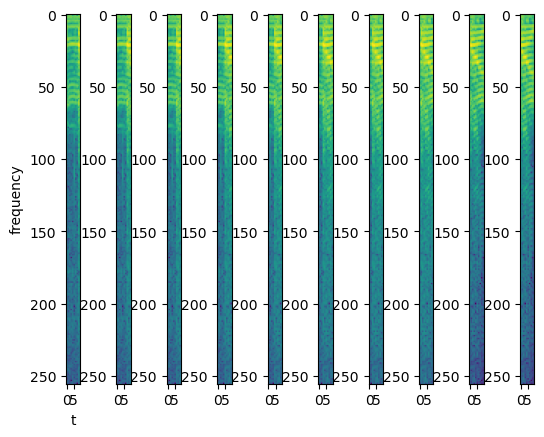

In [ ]:
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.imshow(train_logmag_patches[0,i].T)
    if i == 0:
        plt.xlabel('t')
        plt.ylabel('frequency')
plt.show()